In [18]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import os

In [19]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:")
!ls ~/.keras/models


Available Pretrained Models:
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [20]:
monkey_species = os.listdir('../input/10-monkey-species/training/training')
print("Number of Categories:", len(monkey_species))
print("Categories: ", monkey_species)

Number of Categories: 10
Categories:  ['n5', 'n3', 'n6', 'n4', 'n2', 'n8', 'n0', 'n7', 'n9', 'n1']


In [21]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '../input/10-monkey-species/training/training'
validation_data_dir = '../input/10-monkey-species/validation/validation'
batch_size = 4

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [23]:
nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

In [31]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [32]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

In [34]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [35]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [36]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x1 = list(validation_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1100, title='Class Distribution in Validation Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [37]:
#import inception with pre-trained weights. do not include fully #connected layers
Xception_base = applications.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
# create the full network so we can train on it
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

In [38]:
Xception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


In [39]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1429974548004074471
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15666780570
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9606223296169880803
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [40]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history = Xception_transfer.fit_generator(
    train_generator,
    epochs=10, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/10
275/275 [==============================] - 79s 286ms/step - loss: 2.2783 - acc: 0.1582 - val_loss: 2.1424 - val_acc: 0.3125
Epoch 2/10
275/275 [==============================] - 73s 265ms/step - loss: 2.1577 - acc: 0.3691 - val_loss: 1.9336 - val_acc: 0.5699
Epoch 3/10
275/275 [==============================] - 69s 251ms/step - loss: 1.9987 - acc: 0.5300 - val_loss: 1.6308 - val_acc: 0.7941
Epoch 4/10
275/275 [==============================] - 73s 265ms/step - loss: 1.7589 - acc: 0.6991 - val_loss: 1.2693 - val_acc: 0.8971
Epoch 5/10
275/275 [==============================] - 74s 271ms/step - loss: 1.4695 - acc: 0.7936 - val_loss: 0.9494 - val_acc: 0.9265
Epoch 6/10
275/275 [==============================] - 71s 258ms/step - loss: 1.1878 - acc: 0.8245 - val_loss: 0.6455 - val_acc: 0.9449
Epoch 7/10
275/275 [==============================] - 68s 249ms/step - loss: 0.9417 - acc: 0.8473 - val_loss: 0.4698 - val_acc: 0.9485
Epoch 8/10
275/275 [==============================] - 6

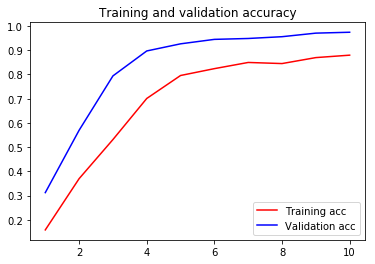

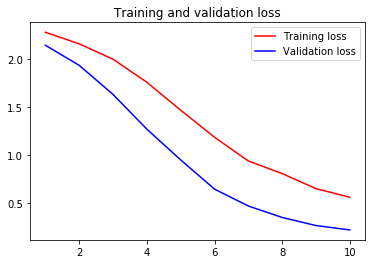

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()